In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('NYPD_Arrest_Data__Year_to_Date_.csv', delimiter = ',')

In [3]:
df.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,199131647,06/30/2019,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,K,78,0,<18,M,BLACK,988709,187224,40.680570,-73.983925
1,199109946,06/30/2019,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN TIME",107.0,BURGLARY,PL 1402000,F,Q,104,0,25-44,M,BLACK,1011210,191981,40.693587,-73.902781
2,199131650,06/30/2019,792.0,WEAPONS POSSESSION 1 & 2,118.0,DANGEROUS WEAPONS,PL 2650303,F,K,73,0,18-24,M,BLACK,1007783,185486,40.675770,-73.915162
3,199126329,06/30/2019,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEANOR",348.0,VEHICLE AND TRAFFIC LAWS,VTL05110A2,M,Q,104,0,25-44,M,WHITE HISPANIC,1017324,198914,40.712596,-73.880699
4,199127207,06/30/2019,339.0,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",341.0,PETIT LARCENY,PL 1552500,M,K,90,0,45-64,M,WHITE HISPANIC,999701,195491,40.703249,-73.944275


In [4]:
# drop rows with null values
df = df.dropna()

In [5]:
df = df[df.OFNS_DESC != 'DISRUPTION OF A RELIGIOUS SERVICE']

In [6]:
df = df[df.OFNS_DESC != 'UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS']

In [7]:
from sklearn.model_selection import train_test_split

In [9]:
train, test = train_test_split(df)

train.shape, test.shape

((84412, 18), (28138, 18))

In [10]:
target = 'OFNS_DESC'
features = ['Latitude','Longitude', 'PERP_RACE', 'PERP_SEX', 'AGE_GROUP', 'ARREST_DATE']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [14]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [15]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_test, y_test))

Validation Accuracy 0.29060345440329804


In [ ]:
# baseline was .14

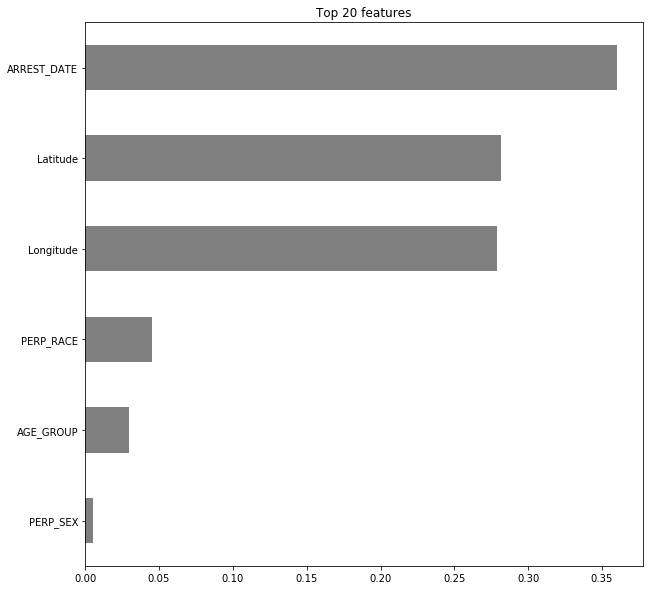

In [16]:
# feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [ ]:
# seems like arrest date is important - will find weather data for each date and also include that as a column in dataframe

In [18]:
# try xgboost
from xgboost import XGBClassifier

In [21]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['PERP_RACE', 'PERP_SEX', 'AGE_GROUP',
                                      'ARREST_DATE'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'PERP_RACE',
                                          'data_type': dtype('O'),
                                          'mapping': BLACK                             1
BLACK HISPANIC                    2
ASIAN / PACIFIC ISLANDER          3
WHITE                             4
WHITE HISPANIC                    5
UNKNOWN                           6
AMERICAN INDIAN/ALASKAN NATIVE    7
NaN                              -2
d...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learnin

In [23]:
pipeline.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_test, y_test))

Validation Accuracy 0.2341673182173573


In [24]:
import eli5
from eli5.sklearn import PermutationImportance

In [48]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['OFNS_DESC'], random_state=42)

In [50]:
target = 'OFNS_DESC'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [51]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [52]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [53]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

PD_CD                0.363063
KY_CD                0.291950
LAW_CAT_CD           0.068045
PD_DESC              0.049114
LAW_CODE             0.016277
ARREST_KEY           0.000047
ARREST_BORO          0.000036
JURISDICTION_CODE    0.000024
PERP_RACE            0.000024
AGE_GROUP           -0.000036
ARREST_DATE         -0.000059
PERP_SEX            -0.000083
Longitude           -0.000178
Y_COORD_CD          -0.000201
Latitude            -0.000201
X_COORD_CD          -0.000213
ARREST_PRECINCT     -0.000261
dtype: float64

In [54]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.3631 ± 0.0045,PD_CD
0.2920 ± 0.0026,KY_CD
0.0680 ± 0.0012,LAW_CAT_CD
0.0491 ± 0.0035,PD_DESC
0.0163 ± 0.0016,LAW_CODE
0.0000 ± 0.0002,ARREST_KEY
0.0000 ± 0.0001,ARREST_BORO
0.0000 ± 0.0002,JURISDICTION_CODE
0.0000 ± 0.0002,PERP_RACE
-0.0000 ± 0.0003,AGE_GROUP


In [ ]:
# the top categories are basically police codes of what the crime was, so probably have to drop those columns from the dataframe